In [ ]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import pickle 

- Calling X_train, y_train, X_valid, y_valid, X_test, y_test from dataframe after preprocessing

In [ ]:
with open("Daily Dataframe Preprocessed.pkl", 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
y_train = data['y_train']
X_valid = data['X_valid']
y_valid = data['y_valid']
X_test = data['X_test']
y_test = data['y_test']

print("DataFrames have been loaded successfully.")

## Setting Hyperparam
- Optuna is a free, open source tool that helps you automatically find the best settings called hyperparameters for your machine learning models. Instead of guessing or trying random values Optuna uses smart algorithms to search efficiently, saving time and improving model performance.
- How does it works:
1. First you define what hyperparameters you want to tune and their possible values. Then you write an objective function that trains your model using these hyperparameters and returns a score showing how well the model did.
2. Optuna runs a series of trials where each trial picks a set of hyperparameters to try. But instead of choosing randomly Optuna uses an intelligent algorithm called Tree structured Parzen Estimator (TPE). This algorithm learns from previous trial results to suggest better hyperparameters over time focusing on promising regions in the search space.
3. To save time Optuna can also prune or stop trials early if they don’t look like they will perform well based on intermediate results which helps it avoids wasting resources on bad trials.
4. You can run many trials sequentially or in parallel to speed up the search. After all trials finish Optuna reports the best hyperparameters found helping you build a better machine learning model with minimal manual effort.
- The below are parameters of CatBoost Model and the range of it we searching to find the best 
1. **`iterations`**
- **Description**: The maximum number of boosting iterations (trees) to train.
- **Range**: `200` to `800`
- **Impact**: Higher values allow the model to learn more complex patterns but may lead to overfitting if too large.

2. **`learning_rate`**
- **Description**: The step size for updating weights during training.
- **Range**: `1e-3` to `0.3` (logarithmic scale)
- **Impact**: 
  - Smaller values make the model learn slower but reduce the risk of overfitting.
  - Larger values speed up training but may lead to suboptimal solutions.

3. **`depth`**
- **Description**: The depth of each tree in the model.
- **Range**: `4` to `10`
- **Impact**: 
  - Deeper trees can capture more complex patterns but may increase the risk of overfitting.
  - Shallower trees are faster to train but may underfit.

4. **`l2_leaf_reg`**
- **Description**: L2 regularization coefficient for leaf values.
- **Range**: `1e-3` to `10.0` (logarithmic scale)
- **Impact**: 
  - Higher values reduce overfitting by penalizing large leaf values.
  - Lower values allow the model to fit the data more closely.

5. **`bagging_temperature`**
- **Description**: Controls the randomness of the data sampling for each tree.
- **Range**: `0.0` to `1.0`
- **Impact**: 
  - Higher values increase randomness, which can improve generalization.
  - Lower values make the model more deterministic.

6. **`random_strength`**
- **Description**: The randomness strength for score calculation in the model.
- **Range**: `1e-3` to `10.0` (logarithmic scale)
- **Impact**: 
  - Higher values increase randomness, which can help avoid overfitting.
  - Lower values make the model more deterministic.

7. **`border_count`**
- **Description**: The number of splits (borders) for numerical features.
- **Range**: `32` to `255`
- **Impact**: 
  - Higher values allow finer granularity for numerical features.
  - Lower values reduce the model's complexity.

8. **`grow_policy`**
- **Description**: The strategy for growing trees.
- **Options**: 
  - `"SymmetricTree"`: Grows balanced trees.
  - `"Depthwise"`: Grows trees depth-wise.
- **Impact**: 
  - `"SymmetricTree"` is faster and more memory-efficient.
  - `"Depthwise"` can capture more complex patterns.

9. **`random_seed`**
- **Description**: The seed for random number generation.
- **Value**: `42`
- **Impact**: Ensures reproducibility of results.

10. **`thread_count`**
- **Description**: The number of threads to use for training.
- **Value**: `-1` (uses all available CPU threads)
- **Impact**: Controls the parallelism of the training process.

&rArr; Our goal of tunning parameters is to maximize the R2

In [ ]:
# import optuna
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# from catboost import CatBoostRegressor

# def objective(trial):
#     """
#     Optuna objective: tối ưu siêu tham số cho CatBoostRegressor (MultiOutput).
#     """
#     param = {
#             "iterations": trial.suggest_int("iterations", 200, 800),
#             "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#             "depth": trial.suggest_int("depth", 4, 10),
#             "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
#             "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#             "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
#             "border_count": trial.suggest_int("border_count", 32, 255),
#             "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
#             "random_seed": 42,
#             "thread_count": -1
#         }

#     model = CatBoostRegressor(**param, verbose=0)  # Tắt log của CatBoost

#     multi_model = MultiOutputRegressor(model)
#     multi_model.fit(X_train, y_train)

#     y_pred = multi_model.predict(X_valid)

#     r2 = r2_score(y_valid, y_pred, multioutput='uniform_average')

#     return r2

d:\PythonCode\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



- **`direction="maximize"`**: Specifies that the goal is to maximize the objective function (e.g., R² score).
- **`pruner=optuna.pruners.MedianPruner(...)`**: Enables early stopping of unpromising trials based on intermediate results, saving time.
- **`n_startup_trials=3`**: Runs at least 3 trials before applying pruning.
- **`n_warmup_steps=30`**: Waits for 30 steps in each trial before deciding whether to prune.

In [ ]:
# # Tạo Optuna study.
# study = optuna.create_study(direction="maximize",
#                             pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=30))

# print("Bắt đầu quá trình tối ưu hóa siêu tham số CatBoostRegressor với Optuna...")
# study.optimize(objective, n_trials=100, n_jobs=1)

# # In kết quả tốt nhất tìm được.
# print("\n------------------------------------------------")
# print("Kết quả tối ưu hóa hoàn tất.")
# print("Trial tốt nhất:")
# print(f"  Giá trị R2 tốt nhất trên tập validation: {study.best_value:.4f}")
# print("  Các siêu tham số tốt nhất: ")
# for key, value in study.best_params.items():
#     print(f"    {key}: {value}")
# print("------------------------------------------------")

[I 2025-11-11 08:51:49,621] A new study created in memory with name: no-name-a639c5a9-e4bc-4720-9dea-dcef7957c7ef


Bắt đầu quá trình tối ưu hóa siêu tham số CatBoostRegressor với Optuna...


[I 2025-11-11 09:02:08,841] Trial 0 finished with value: 0.7672294288815857 and parameters: {'iterations': 501, 'learning_rate': 0.0059874564418770735, 'depth': 10, 'l2_leaf_reg': 0.051040665527344015, 'bagging_temperature': 0.879789520939282, 'random_strength': 0.49698667423491627, 'border_count': 120, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.7672294288815857.
[I 2025-11-11 09:14:29,684] Trial 1 finished with value: 0.6258735403419189 and parameters: {'iterations': 692, 'learning_rate': 0.0017993495138759503, 'depth': 10, 'l2_leaf_reg': 1.9161709125378368, 'bagging_temperature': 0.9956245772416613, 'random_strength': 0.0359346492341877, 'border_count': 101, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.7672294288815857.
[I 2025-11-11 09:15:11,391] Trial 2 finished with value: 0.7696659123363887 and parameters: {'iterations': 735, 'learning_rate': 0.028985842419094958, 'depth': 7, 'l2_leaf_reg': 2.7902829870597636, 'bagging_temperature': 0.917189100244187


------------------------------------------------
Kết quả tối ưu hóa hoàn tất.
Trial tốt nhất:
  Giá trị R2 tốt nhất trên tập validation: 0.7840
  Các siêu tham số tốt nhất: 
    iterations: 526
    learning_rate: 0.010169049430216587
    depth: 4
    l2_leaf_reg: 0.0032931626764724988
    bagging_temperature: 0.5432852312432698
    random_strength: 0.3256222978316959
    border_count: 139
    grow_policy: SymmetricTree
------------------------------------------------


- Save best model hyperparams to a file

## Final Test
- Train model with optuna hyperparams and test in the test set

In [ ]:
from joblib import load
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load best model từ file best_daily_model.joblib
best_model = load('Best Daily Model Hyperparams.joblib')

# Dự đoán trên tập test
y_pred = best_model.predict(X_test)

# Tính toán các chỉ số đánh giá cho từng label
labels = y_test.columns  # Lấy tên các label
metrics = {}

for i, label in enumerate(labels):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    metrics[label] = {"R2": r2, "RMSE": rmse, "MAE": mae}

# In kết quả cho từng label
print("\nĐánh giá trên từng label:")
for label, metric in metrics.items():
    print(f"\nLabel: {label}")
    print(f"  R²: {metric['R2']:.4f}")
    print(f"  RMSE: {metric['RMSE']:.4f}")
    print(f"  MAE: {metric['MAE']:.4f}")

# Tính toán các chỉ số đánh giá macro
macro_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
macro_rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
macro_mae = mean_absolute_error(y_test, y_pred)

# In kết quả macro
print("\nĐánh giá macro:")
print(f"  Macro R²: {macro_r2:.4f}")
print(f"  Macro RMSE: {macro_rmse:.4f}")
print(f"  Macro MAE: {macro_mae:.4f}")


Đánh giá trên từng label:

Label: target_temp_t+1
  R²: 0.9193
  RMSE: 1.3199
  MAE: 1.0230

Label: target_temp_t+2
  R²: 0.8458
  RMSE: 1.8257
  MAE: 1.4316

Label: target_temp_t+3
  R²: 0.8176
  RMSE: 1.9870
  MAE: 1.5793

Label: target_temp_t+4
  R²: 0.8060
  RMSE: 2.0489
  MAE: 1.6413

Label: target_temp_t+5
  R²: 0.8050
  RMSE: 2.0544
  MAE: 1.6441

Đánh giá macro:
  Macro R²: 0.8388
  Macro RMSE: 1.8677
  Macro MAE: 1.4639


In [71]:
# In ra nhiệt độ dự đoán và thực tế cho từng ngày trong 5 ngày
for h in horizons:
    print(f"\nNgày {h}:")
    print(f"  Nhiệt độ thực tế: {y_test[f'target_temp_t+{h}'].values[:5]}")
    print(f"  Nhiệt độ dự đoán: {y_pred[:, horizons.index(h)][:5]}")

# In các metrics của từng ngày
print("\nMetrics cho từng ngày:")
for label, metric in metrics.items():
    print(f"\nLabel: {label}")
    print(f"  R²: {metric['R2']:.4f}")
    print(f"  RMSE: {metric['RMSE']:.4f}")
    print(f"  MAE: {metric['MAE']:.4f}")

# In macro metrics
print("\nMacro Metrics:")
print(f"  Macro R²: {macro_r2:.4f}")
print(f"  Macro RMSE: {macro_rmse:.4f}")
print(f"  Macro MAE: {macro_mae:.4f}")


Ngày 1:
  Nhiệt độ thực tế: [25.1 24.7 26.3 26.5 26. ]
  Nhiệt độ dự đoán: [21.80833313 24.37514285 24.16412055 25.51579137 25.55755005]

Ngày 2:
  Nhiệt độ thực tế: [24.7 26.3 26.5 26.  24.4]
  Nhiệt độ dự đoán: [22.79458572 22.96128891 23.07693173 24.1507862  24.02865012]

Ngày 3:
  Nhiệt độ thực tế: [26.3 26.5 26.  24.4 23.2]
  Nhiệt độ dự đoán: [22.68980422 22.37889757 22.55000072 23.1314594  23.3899234 ]

Ngày 4:
  Nhiệt độ thực tế: [26.5 26.  24.4 23.2 25.4]
  Nhiệt độ dự đoán: [22.70158494 22.66807249 22.72891278 22.91815946 23.35924989]

Ngày 5:
  Nhiệt độ thực tế: [26.  24.4 23.2 25.4 27.4]
  Nhiệt độ dự đoán: [22.745843   22.73174905 23.18812509 23.21081596 23.41602028]

Metrics cho từng ngày:

Label: target_temp_t+1
  R²: 0.9193
  RMSE: 1.3199
  MAE: 1.0230

Label: target_temp_t+2
  R²: 0.8458
  RMSE: 1.8257
  MAE: 1.4316

Label: target_temp_t+3
  R²: 0.8176
  RMSE: 1.9870
  MAE: 1.5793

Label: target_temp_t+4
  R²: 0.8060
  RMSE: 2.0489
  MAE: 1.6413

Label: target_temp_t+

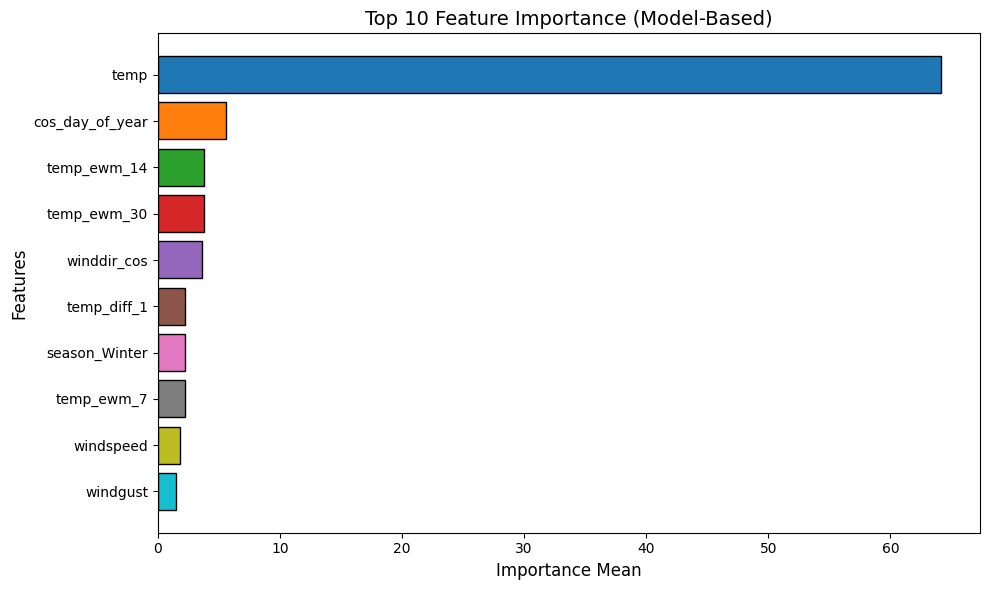

In [72]:
import matplotlib.pyplot as plt

# Lấy tên các feature từ X_train
feature_names = X_train.columns

# Tính toán feature importance từ mô hình đã huấn luyện
feature_importances = best_model.estimators_[0].feature_importances_

# Tạo DataFrame để sắp xếp và chọn top 10 feature
top_10_features = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': feature_importances
}).sort_values(by='Importance_Mean', ascending=False).head(10)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(range(len(top_10_features)))  # Mỗi feature có màu khác nhau
plt.barh(top_10_features['Feature'], top_10_features['Importance_Mean'], color=colors, edgecolor='black')
plt.xlabel('Importance Mean', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 10 Feature Importance (Model-Based)', fontsize=14)
plt.gca().invert_yaxis()  # Đảo ngược trục y để feature quan trọng nhất ở trên cùng
plt.tight_layout()
plt.show()